In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


In [4]:
df['Keywords'] = df['Keywords'].str.split(',')

In [5]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Classification Problem: Find whether the answer for a question is correct or not.

- Given the inputs Student Country, Type of Answer, Question Level and Keywords, classify whether the answer is correct.
- This is a Binary Classification problem.
- We apply different classical Machine Learning models: Naive Bayes, Decision Trees, Random Forest Regressor, KNN and Logistic Regression to perform comparative analysis.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

multi_label_cols = ['Question Level', 'Topic', 'Subtopic']
preproc_df = df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [7]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [8]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [9]:
preproc_df = pd.get_dummies(preproc_df, columns=['Student Country'], drop_first=True)

In [10]:
preproc_df.head()

,Student ID,Question ID,Type of Answer,Question_Level_Advanced,Question_Level_Basic,Topic_Analytic_Geometry,Topic_Complex_Numbers,Topic_Differential_Equations,Topic_Differentiation,Topic_Fundamental_Mathematics,...,keyword_97,keyword_98,keyword_99,Student Country_Italy,Student Country_Lithuania,Student Country_Portugal,Student Country_Romania,Student Country_Russian Federation,Student Country_Slovenia,Student Country_Spain
0,647,77,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,False,False,False,False,False,False,False
1,41,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,False,False,True,False,False,False,False
2,340,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,False,False,True,False,False,False,False
3,641,77,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,True,False,False,False,False,False,False
4,669,77,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,False,False,True,False,False,False,False


In [11]:
X = preproc_df.drop(["Student ID", "Question ID", "Type of Answer"], axis=1)
y = preproc_df["Type of Answer"]

In [12]:
X.shape

(9546, 150)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
classifiers = {
    "LogisticRegression": LogisticRegression(solver="liblinear"),
    "NaiveBayes": BernoulliNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(24),
    "SVM": SVC(gamma='auto', probability=True),
    "RFR": RandomForestClassifier(n_estimators=100, random_state=42)
}

param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"]
    },
    "NaiveBayes": {
        "alpha": [0.1, 0.5, 1.0, 2.0, 5.0],
        "binarize": [0.0, 0.1, 0.5, 1.0]
    },
    "DecisionTree": {
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20, 30, 40, 50],
        "min_samples_leaf": [2, 5, 10, 20, 30, 40, 50],
        "criterion": ["gini", "entropy"]
    },
    "KNN": {
        "n_neighbors": list(range(1, 500, 2)),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear"],
    },
    "RFR": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 2, 5, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20, 30, 40, 50],
        "min_samples_leaf": [2, 5, 10, 20, 30, 40, 50],
        "criterion": ["gini", "entropy"]
    }
}

In [15]:
best_models = {}
best_scores = {}

for name, model in classifiers.items():
    print(f"Optimizing {name}...")
    
    search = GridSearchCV(model, param_grids[name], scoring="accuracy", n_jobs=-1)
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {search.best_score_:.4f}\n")

Optimizing LogisticRegression...
Best Parameters for LogisticRegression: {'C': 1, 'penalty': 'l1'}
Best Cross-Validation Accuracy: 0.5875

Optimizing NaiveBayes...
Best Parameters for NaiveBayes: {'alpha': 5.0, 'binarize': 0.5}
Best Cross-Validation Accuracy: 0.5495

Optimizing DecisionTree...
Best Parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best Cross-Validation Accuracy: 0.5891

Optimizing KNN...
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 133, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.5919

Optimizing SVM...
Best Parameters for SVM: {'C': 10, 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.5860

Optimizing RFR...
Best Parameters for RFR: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.5866



In [20]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
import pandas as pd

def evaluate_models(best_models, X, y):
    results = []

    for name, model in best_models.items():
        y_pred = cross_val_predict(model, X, y)
        y_probs = cross_val_predict(model, X, y, method="predict_proba")[:, 1]
        
        acc = accuracy_score(y, y_pred)
        f1_weighted = f1_score(y, y_pred, average="weighted")
        f1_macro = f1_score(y, y_pred, average="macro")
        roc_auc = roc_auc_score(y, y_probs)

        results.append({
            "Classifier": name, 
            "Accuracy": acc, 
            "F1_Weighted": f1_weighted, 
            "F1_Macro": f1_macro,
            "ROC_AUC": roc_auc
        })
    
    df_results = pd.DataFrame(results)
    print(df_results)

In [21]:
evaluate_models(best_models, X_test, y_test)

           Classifier  Accuracy  F1_Weighted  F1_Macro   ROC_AUC
0  LogisticRegression  0.553927     0.542432  0.538244  0.556564
1          NaiveBayes  0.545550     0.545005  0.543500  0.546135
2        DecisionTree  0.556545     0.547289  0.543489  0.562126
3                 KNN  0.557068     0.516823  0.509287  0.537826
4                 SVM  0.551309     0.543053  0.539410  0.547782
5                 RFR  0.571728     0.565479  0.562322  0.573335


### Top 3 performing Classifiers without Ensemble: Decision Tree, KNN and Logistic Regression.

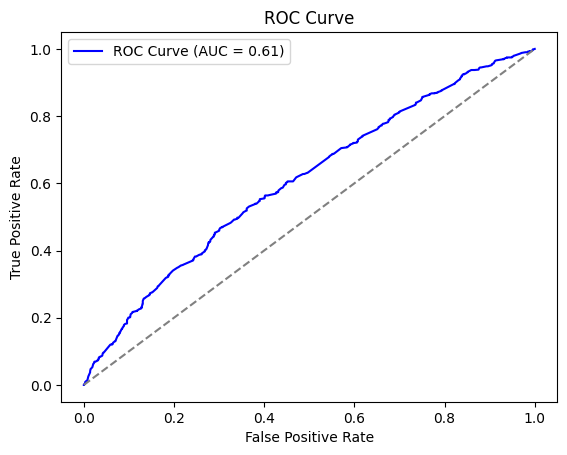

In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

model = best_models["RFR"]
# Get probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

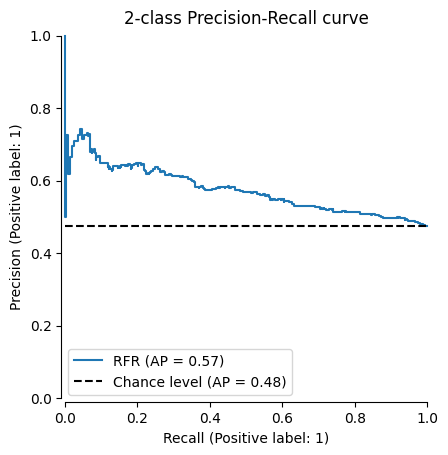

In [24]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_models["RFR"], X_test, y_test, name="RFR", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")